# compile SDSS galaxy spectra
I will compile SDSS spectra from the DR16 (latest) SDSS data reduction

In [1]:
import os
import numpy as np 
import astropy.table as aTable
import astropy.io.fits as fits

import urllib.request

In [2]:
import matplotlib.pyplot as plt

## read in SDSS DR16 specobj catalog

In [3]:
# specObj-dr16.fits can be downloaded from 
# https://data.sdss.org/sas/dr16/sdss/spectro/redux/specObj-dr16.fits
specobj = aTable.Table.read('/global/cscratch1/sd/chahah/arcoiris/specObj-dr16.fits')

In [4]:
specobj[:5]

SURVEY,INSTRUMENT,CHUNK,PROGRAMNAME,PLATERUN,PLATEQUALITY,PLATESN2,DEREDSN2,LAMBDA_EFF,BLUEFIBER,ZOFFSET,SNTURNOFF,NTURNOFF,SPECPRIMARY,SPECSDSS,SPECLEGACY,SPECSEGUE,SPECSEGUE1,SPECSEGUE2,SPECBOSS,BOSS_SPECOBJ_ID,SPECOBJID,FLUXOBJID,BESTOBJID,TARGETOBJID,PLATEID,NSPECOBS,FIRSTRELEASE,RUN2D,RUN1D,DESIGNID,CX,CY,CZ,XFOCAL,YFOCAL,SOURCETYPE,TARGETTYPE,THING_ID_TARGETING,THING_ID,PRIMTARGET,SECTARGET,LEGACY_TARGET1,LEGACY_TARGET2,SPECIAL_TARGET1,SPECIAL_TARGET2,SEGUE1_TARGET1,SEGUE1_TARGET2,SEGUE2_TARGET1,SEGUE2_TARGET2,MARVELS_TARGET1,MARVELS_TARGET2,BOSS_TARGET1,BOSS_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,EBOSS_TARGET_ID,ANCILLARY_TARGET1,ANCILLARY_TARGET2,SPECTROGRAPHID,PLATE,TILE,MJD,FIBERID,OBJID [5],PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN [10],NPOLY,THETA [10],VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN_ALL,SN_MEDIAN [5],CHI68P,FRACNSIGMA [10],FRACNSIGHI [10],FRACNSIGLO [10],SPECTROFLUX [5],SPECTROFLUX_IVAR [5],SPECTROSYNFLUX [5],SPECTROSYNFLUX_IVAR [5],SPECTROSKYFLUX [5],ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,ELODIE_FILENAME,ELODIE_OBJECT,ELODIE_SPTYPE,ELODIE_BV,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,ELODIE_Z,ELODIE_Z_ERR,ELODIE_Z_MODELERR,ELODIE_RCHI2,ELODIE_DOF,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,Z_PERSON,CLASS_PERSON,Z_CONF_PERSON,COMMENTS_PERSON,CALIBFLUX [5],CALIBFLUX_IVAR [5]
bytes6,bytes4,bytes16,bytes27,bytes16,bytes8,float32,float32,float32,int32,float32,float32,int32,uint8,uint8,uint8,uint8,uint8,uint8,uint8,int32,bytes22,bytes19,bytes19,bytes22,bytes20,int16,bytes4,bytes7,bytes7,int32,float64,float64,float64,float32,float32,bytes25,bytes8,int64,int32,int32,int32,int32,int32,int64,int64,int32,int32,int32,int32,int32,int32,int64,int64,int64,int64,int64,int64,int64,int64,int16,int32,int32,int32,int32,int32,float64,float64,bytes6,bytes21,float32,float32,float32,int32,float32,bytes24,int32,int32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,bytes25,bytes21,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,bytes6,bytes21,float32,float32,int32,int32,bytes1,float32,float32
sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489676975171584,1237648720142401611,1237648720142401611,284722522357889,299489402097264640,2,dr7,26,,-1,-0.8358054467762618,0.5487248767591583,-0.018173188074197,179.03609,-240.32146,GALAXY,SCIENCE,0,0,96,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,1,756 .. 129,146.71421,-1.0413043,GALAXY,,0.021275453,9.121824e-06,1.0740697,3770,3.8736846,spEigenGal-53724.fits,0 .. -1,3,0.010862294 .. 0.0,135.89957,4.085766,0.0,0.0,1677.3035,2168.0,2117,3806.2737,9202.377,0.3777,0,38.055374,5.4701285 .. 38.357212,0.9616138,0.3007678 .. 0.0,0.15064867 .. 0.0,0.15011914 .. 0.0,47.65952 .. 642.4805,1.3083245 .. 0.44190055,39.69294 .. 645.40283,2.9729717 .. 0.5970152,9.833003 .. 156.5848,230752256,266272768,20.858,16.1727,13.4718,13.3075,10.6615,7.67533,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,,,0.0,0.0,0,0,,30.750963 .. 714.2892,3.9342144 .. 0.11776969
sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489951853078528,1237648720142532891,1237648720142532891,284722522489067,299489402097264640,2,dr7,26,,-1,-0.837778850074094,0.5457359947228211,-0.01728648120415685,223.89526,-229.37148,GALAXY,SCIENCE,0,0,64,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,2,756 .. 235,146.91945,-0.99049175,GALAXY,,0.21392463,5.2343898e-05,1.3313361,3781,0.17913103,spEigenGal-53724.fits,0 .. -1,3,0.0010820967 .. 0.0,140.48119,15.037567,0.0,0.0,2411.1309,2168.0,2117,3806.2737,9202.377,0.3788,0,6.40414,0.28766504 .. 6.839629,1.128

## only keep SDSS galaxies with some spectroscopic quality flags
- `SURVEY = 'sdss'` --- SDSS  
- `PLATEQUALITY = 'good'` --- a good science quality plate
- `TARGETTYPE = 'SCIENCE'` --- science target and not sky or standard stars

data model detail can be found in https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html

In [5]:
keep = ((specobj['SURVEY'] == 'sdss  ') & # SDSS survey
        (specobj['PLATEQUALITY'] == 'good    ') & 
        (specobj['TARGETTYPE'] == 'SCIENCE ') 
       )
print(np.sum(keep))

883049


## lets also impose some redshift sanity cuts

In [6]:
zcut = ((specobj['Z'] > 0.) & (specobj['Z_ERR'] < 1e-4))
print(np.sum(keep & zcut) )

687915


## only keep galaxy spectra
- `SOURCETYPE = 'GALAXY'` --- based on imaging (apparently similar to objtype in DR8, whatever that means) 
- `CLASS= 'GALAXY'` --- based on best spectroscopic classification

In [7]:
is_galaxy = ((specobj['SOURCETYPE'] == 'GALAXY                   ') &
             (specobj['CLASS'] == 'GALAXY'))
print(np.sum(keep & zcut & is_galaxy))

545954


In [8]:
specobj = specobj[keep & zcut & is_galaxy]

                     
AGN                  
AGN BROADLINE        
BROADLINE            
STARBURST            
STARBURST BROADLINE  
STARFORMING          
STARFORMING BROADLINE


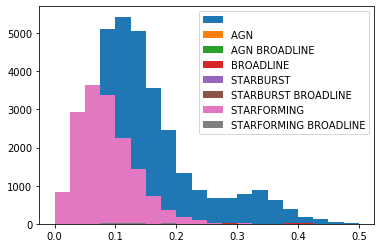

In [9]:
for subclass in np.unique(specobj['SUBCLASS']): 
    print(subclass)
    plt.hist(specobj['Z'][specobj['SUBCLASS'] == subclass][::10], bins=20, range=(0., 0.5), label=subclass)
plt.legend()

# Download spectra for these galaxies
We'll download spectra individually for the first 100,000 galaxy spectra from https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra


In [10]:
dat_dir = '/global/cscratch1/sd/chahah/arcoiris'

def download_spectra(plate, mjd, fiberid): 
    url = 'https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/%s/spec-%s-%i-%s.fits' % (str(plate).zfill(4), str(plate).zfill(4), mjd, str(fiberid).zfill(4))    
    flocal = os.path.join(dat_dir, 'sdss_spectra', os.path.basename(url))
    if not os.path.isfile(flocal):
        print(plate, mjd, fiberid)
        urllib.request.urlretrieve(url, flocal)
    return None

In [11]:
def read_sdss_spectra(plate, mjd, fiberid): 
    '''read sdss spectra downloaded from https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/
    '''
    flocal = os.path.join(dat_dir, 'sdss_spectra', 'spec-%s-%i-%s.fits' % (str(plate).zfill(4), mjd, str(fiberid).zfill(4)))
    if not os.path.isfile(flocal): 
        raise ValueError
    hdulist = fits.open(flocal)
    
    header = hdulist[0].header
    meta = hdulist[2].data
    data = hdulist[1].data

    # metadata from header
    z = meta['Z']
    zerr = meta['Z_ERR']

    # read data
    logw = data['loglam']
    spec = data['flux']
    ivar = data['ivar'] 
    mask = data['and_mask'].astype(bool)
    ivar[mask] = 0.

    return logw, spec, ivar, mask, z, zerr

In [ ]:
Nspec = 100000
i, j = 0, 0 

wave = np.arange(3.578, 3.97, 0.0001).astype(np.float32) # padded wavelength range

plates, mjds, fiberids = [], [], []
while i < Nspec: 
    plate, mjd, fiberid = specobj['PLATE'][j], specobj['MJD'][j], specobj['FIBERID'][j]
    
    download_spectra(plate, mjd, fiberid)
    
    try: 
        x = read_sdss_spectra(plate, mjd, fiberid)
    except (IndexError, OSError): 
        j += 1
        continue 
    if np.sum(x[1]) == 0: 
        j += 1
        continue
    if x[4] <= 0: 
        j += 1
        continue
    
    if i == 0: 
        specs = np.zeros((Nspec, len(wave)), dtype=np.float32)
        ivars = np.zeros((Nspec, len(wave)), dtype=np.float32)
        masks = np.zeros((Nspec, len(wave)), dtype=np.bool)
        
        zreds = np.zeros(Nspec, dtype=np.float32)
        zerrs = np.zeros(Nspec, dtype=np.float32)

    iw = int((x[0][0] - wave[0])/0.0001)
    if iw < 0: 
        j += 1
        continue
    specs[i,iw:iw+len(x[1])] = x[1]
    ivars[i,iw:iw+len(x[1])] = x[2]
    masks[i,iw:iw+len(x[1])] = x[3]
    zreds[i] = x[4]
    zerrs[i] = x[5]
    
    plates.append(plate)
    mjds.append(mjd)
    fiberids.append(fiberid)
    
    i += 1
    j += 1
    
    if (i % 1000) == 0: print(i)

#trim the data bit 
iw0 = np.arange(len(wave))[np.sum(specs != 0., axis=0) > 0][0]
iw1 = np.arange(len(wave))[np.sum(specs != 0., axis=0) > 0][-1]
wave = wave[iw0:iw1+1]
specs = specs[:i,iw0:iw1+1]
ivars = ivars[:i,iw0:iw1+1]
masks = masks[:i,iw0:iw1+1]
zreds = zreds[:i]
zerrs = zerrs[:i]

fout = os.path.join(dat_dir, 'sdss_spectra.%i.npz' % i)
print("saving to %s" % fout)
np.savez(fout,
         wave=wave,
         spectra=specs,
         mask=masks,
         ivar=ivars,
         z=zreds, 
         zerr=zerrs,
         plate=np.array(plates).astype(np.int32),
         mjd=np.array(mjds).astype(np.int32),
         fiber=np.array(fiberids).astype(np.int32))

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
54000
55000
56000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
517 52024 274
517 52024 275
517 52024 276
517 52024 278
517 52024 279
517 52024 280
517 52024 284
517 52024 285
517 52024 286
517 52024 287
517 52024 288
517 52024 289
517 52024 290
517 52024 291
517 52024 292
517 52024 293
517 52024 294
517 52024 295
517 52024 296
517 52024 297
517 52024 298
517 52024 299
517 52024 300
517 52024 302
517 52024 303
517 52024 304
517 52024 305
517 52024 308
517 52024 309
517 52024 311
517 52024 312
517 52024 313
517 52024 314
517 52024 315
517 52024 316
517 52024 318
517 52024 319
517 52024 320
517 52024 321
517 520